Notebook to calculate and save place field correlation mean and hierarchically bootstrapped values

In [1]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror, fix_xlabels
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp
from helpers import flatten
from stats_utils import resample, get_bootstrap_prob, get_bootstrap_prob_paired, resample_corrs_paired
from subjects import save_df, load_df

### Definitions

In [2]:
day_dict = {"Before" : [-2, -1], "Before v After" : [-1, 1], "After" : [1, 2], "After2": [2, 7],
            "Before v STM" : [-1, 4], "STM v After" : [4, 1]}

In [3]:
day_dict_paired = {"Before v After All Days": [[-2, 1], [-2, 2], [-1, 1], [-1, 2]],
                   "Before v After Paired" : [[-1, 1]]}

In [4]:
gen_sesh_id = lambda row : f"{row['arena1']}{row['day1']}_{row['arena2']}{row['day2']}"

In [5]:
gen_pair_id = lambda row : f"{row['day1']}_{row['day2']}"

In [11]:
savename_dict = {"Before": "before", "Before v After": "before_after", "After": "after", 
                 "After2": "after2", "Before v STM": "before_stm", "STM v After": "stm_after",
                "Before v After All Days": "before_after_all_paired", "Before v After Paired": "before_after_paired"}

## 2D Place field correlations

### Before (Day -2 to -1) correlations

In [55]:
from copy import copy
corr_df2 = copy(corr_df)
corr_df2.insert(9, column="shuf_corrs_sm", value=pd.concat(shuf_df_list).corrs_sm.values)
corr_df2

,Group,session_pair,mouse,arena1,day1,arena2,day2,pair_no,corrs_sm,shuf_corrs_sm
0,ANI,Open-2_Open-1,Marble17,Open,-2,Open,-1,0,0.101313,-0.098920
1,ANI,Open-2_Open-1,Marble17,Open,-2,Open,-1,1,0.021653,0.137479
2,ANI,Open-2_Open-1,Marble17,Open,-2,Open,-1,2,0.074947,0.513872
3,ANI,Open-2_Open-1,Marble17,Open,-2,Open,-1,3,0.254538,-0.191718
4,ANI,Open-2_Open-1,Marble17,Open,-2,Open,-1,4,0.032425,0.225420
...,...,...,...,...,...,...,...,...,...,...
549,ANI,Open-2_Open-1,Marble25,Open,-2,Open,-1,549,0.050210,0.132236
550,ANI,Open-2_Open-1,Marble25,Open,-2,Open,-1,550,0.489579,0.072793
551,ANI,Open-2_Open-1,Marble25,Open,-2,Open,-1,551,-0.646671,0.015050
552,ANI,Open-2_Open-1,Marble25,Open,-2,Open,-1,552,0.844345,-0.050282


In [205]:
n_iter = 10000
for epoch in ["Before v After Paired", "Before v After All Days"]:
    df_bs, corr_df_all, shuf_df_all = [], [], []
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list, df_shuf_list = [], []

        for mouse in mice:
            for days in day_dict_paired[epoch]:
                df_list.append(pfs.pf_corrs_to_df(mouse, "Shock", days[0], "Shock", days[1]))
                df_list.append(pfs.pf_corrs_to_df(mouse, 'Open', days[0], 'Open', days[1]))

                df_shuf_list.append(pfs.pf_corrs_to_df(mouse, "Shock", days[0], "Shock", days[1], shuf_map=True))
                df_shuf_list.append(pfs.pf_corrs_to_df(mouse, "Open", days[0], "Open", days[1], shuf_map=True))

        shuf_df = pd.concat(df_shuf_list)
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="day_pair", value=corr_df.apply(gen_pair_id, axis=1))
        corr_df.insert(9, column="shuf_corrs_sm", value=shuf_df.corrs_sm.values)
        corr_df_all.append(corr_df)
        
        df_group = []
        for ii in tqdm(range(n_iter)):
            df_split = [corr_df[corr_df.arena1 == "Shock"], corr_df[corr_df.arena1 == "Open"]]
            df_rs = resample_corrs_paired(df_split)
            df_rs_mean = df_rs.drop(columns=["day1", "day2", "pair_no", "mouse_rs"]).groupby(['arena1']).mean(numeric_only=True).reset_index()
            df_rs_mean.loc[df_rs_mean.arena1 == "Open", "arena1"] = "Neutral"
            df_rs_mean.loc[:, "boot_no"] = ii
            df_group.append(df_rs_mean)
        df_group = (pd.concat(df_group, axis=0, ignore_index=True)
                     .pivot(columns="arena1", values=["corrs_sm", "shuf_corrs_sm"], index="boot_no")
                     .reset_index())
        df_group.insert(0, "Group", group_name)
        df_bs.append(df_group)

    df_bs = pd.concat(df_bs, axis=0, ignore_index=True)
    corr_df_all = pd.concat(corr_df_all)
    corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
    corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"
    
    save_str = savename_dict[epoch]
    save_df(corr_df_all, f"group_pf_corrs_{save_str}")
    save_df(df_bs, f"group_pf_corrs_{save_str}_bootstrap")

Loading previous 2d placefield analysis for Marble07 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble07 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble07 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble07 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble12 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble12 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble12 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble12 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble24 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble24 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble24 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble24 Open day -1 to Open day 1
Loading previous 2d placefield analysis 

100%|██████████████████████████████████████| 10000/10000 [00:56<00:00, 176.47it/s]


Loading previous 2d placefield analysis for Marble06 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble06 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble11 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble11 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble11 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble11 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble29 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble29 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble29 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble29 Open day -1 to Open day 1


100%|██████████████████████████████████████| 10000/10000 [00:51<00:00, 192.38it/s]


Loading previous 2d placefield analysis for Marble17 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble17 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble18 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble18 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble18 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble18 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble19 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble19 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble19 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble19 Open day -1 to Open day 1
Loading previous 2d placefield analysis 

100%|███████████████████████████████████████| 10000/10000 [02:41<00:00, 61.73it/s]


group_pf_corrs_before_after_paired.csv saved
group_pf_corrs_before_after_paired_bootstrap.csv saved
Loading previous 2d placefield analysis for Marble07 Shock day -2 to Shock day 1
Loading previous 2d placefield analysis for Marble07 Open day -2 to Open day 1
Loading previous 2d placefield analysis for Marble07 Shock day -2 to Shock day 1
Loading previous 2d placefield analysis for Marble07 Open day -2 to Open day 1
Loading previous 2d placefield analysis for Marble07 Shock day -2 to Shock day 2
Loading previous 2d placefield analysis for Marble07 Open day -2 to Open day 2
Loading previous 2d placefield analysis for Marble07 Shock day -2 to Shock day 2
Loading previous 2d placefield analysis for Marble07 Open day -2 to Open day 2
Loading previous 2d placefield analysis for Marble07 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble07 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble07 Shock day -1 to Shock day 1
Loading previous 2d

100%|█████████████████████████████████████| 10000/10000 [1:42:19<00:00,  1.63it/s]


Loading previous 2d placefield analysis for Marble06 Shock day -2 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Open day -2 to Open day 1
Loading previous 2d placefield analysis for Marble06 Shock day -2 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Open day -2 to Open day 1
Loading previous 2d placefield analysis for Marble06 Shock day -2 to Shock day 2
Loading previous 2d placefield analysis for Marble06 Open day -2 to Open day 2
Loading previous 2d placefield analysis for Marble06 Shock day -2 to Shock day 2
Loading previous 2d placefield analysis for Marble06 Open day -2 to Open day 2
Loading previous 2d placefield analysis for Marble06 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble06 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Open day -1 to Open day 1
Loading previous 2d placefield analysis 

100%|█████████████████████████████████████| 10000/10000 [3:33:38<00:00,  1.28s/it]


Loading previous 2d placefield analysis for Marble17 Shock day -2 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Open day -2 to Open day 1
Loading previous 2d placefield analysis for Marble17 Shock day -2 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Open day -2 to Open day 1
Loading previous 2d placefield analysis for Marble17 Shock day -2 to Shock day 2
Loading previous 2d placefield analysis for Marble17 Open day -2 to Open day 2
Loading previous 2d placefield analysis for Marble17 Shock day -2 to Shock day 2
Loading previous 2d placefield analysis for Marble17 Open day -2 to Open day 2
Loading previous 2d placefield analysis for Marble17 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Open day -1 to Open day 1
Loading previous 2d placefield analysis for Marble17 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Open day -1 to Open day 1
Loading previous 2d placefield analysis 

100%|█████████████████████████████████████| 10000/10000 [4:42:15<00:00,  1.69s/it]


group_pf_corrs_before_after_all_paired.csv saved
group_pf_corrs_before_after_all_paired_bootstrap.csv saved


In [278]:
df_group.Group == "ANI"

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Name: Group, Length: 10000, dtype: bool

In [237]:
df_bs['Group'] == 'Learners'

,Unnamed: 0_level_1
0,True
1,True
2,True
3,True
4,True
...,...
29995,False
29996,False
29997,False
29998,False


In [288]:
idx

MultiIndex([('Learners',    0, 0.1620435465775148, 0.1951624272548151, ...),
            ('Learners',    1, 0.1180480916541518, 0.1193109372220323, ...),
            ('Learners',    2, 0.4013917911223958, 0.0722743646838217, ...),
            ('Learners',    3, 0.2014336763697536, 0.1994749316158116, ...),
            ('Learners',    4, 0.1108344137734189, 0.2173509220504415, ...),
            ('Learners',    5, 0.1853279766925701, 0.2331229173149788, ...),
            ('Learners',    6, 0.1123674594041969, 0.2385191942002325, ...),
            ('Learners',    7, 0.1823803046053996, 0.1902226000361371, ...),
            ('Learners',    8,   0.15913687244593, 0.2166869337746946, ...),
            ('Learners',    9,  0.320131080186732, 0.0967075358256506, ...),
            ...
            (     'ANI', 9990, 0.1231708872415957, 0.1289436042599021, ...),
            (     'ANI', 9991, 0.2270525493147929, 0.1769605298374449, ...),
            (     'ANI', 9992, 0.1724807199996834, 0.1837439

In [303]:
df_bs.columns

MultiIndex([(        'Group', 'Unnamed: 0_level_1'),
            (      'boot_no', 'Unnamed: 1_level_1'),
            (     'corrs_sm',            'Neutral'),
            (     'corrs_sm',              'Shock'),
            ('shuf_corrs_sm',            'Neutral'),
            ('shuf_corrs_sm',              'Shock')],
           )

In [314]:
df_bs2 = deepcopy(df_bs)
# df_bs2.columns.set_names([["Group", "boot_no", "corrs_sm", "corrs_sm", "shuf_corrs_sm", "shuf_corrs_sm"],
#                           ["", "", "Neutral", "Shock", "Neutral", "Shock"]])
# df_bs2.columns.set_names([('Group', ''), ('boot_no', ''), ('corrs_sm', 'Neutral'), 
#                ('corrs_sm', 'Shock'), ('shuf_corrs_sm', 'Neutral'), ('shuf_corrs_sm', 'Shock')], inplace=True)
idx = pd.MultiIndex.from_frame(df_bs2)
idx.set_names([('Group', ''), ('boot_no', ''), ('corrs_sm', 'Neutral'), 
               ('corrs_sm', 'Shock'), ('shuf_corrs_sm', 'Neutral'), ('shuf_corrs_sm', 'Shock')], inplace=True)
# idx.rename([('Group', ''), ('boot_no', ''), ('corrs_sm', 'Neutral'), 
#                ('corrs_sm', 'Shock'), ('shuf_corrs_sm', 'Neutral'), ('shuf_corrs_sm', 'Shock')], inplace=True)
# df_bs2.set_index(idx)
idx
df_bs2.columns = idx.names

In [315]:
df_bs2

,"(Group, )","(boot_no, )","(corrs_sm, Neutral)","(corrs_sm, Shock)","(shuf_corrs_sm, Neutral)","(shuf_corrs_sm, Shock)"
0,Learners,0,0.162044,0.195162,0.028371,0.056869
1,Learners,1,0.118048,0.119311,0.027619,0.074829
2,Learners,2,0.401392,0.072274,-0.000115,0.101039
3,Learners,3,0.201434,0.199475,0.019258,0.119862
4,Learners,4,0.110834,0.217351,0.019263,0.078659
...,...,...,...,...,...,...
29995,ANI,9995,0.253299,0.215664,0.022324,0.104155
29996,ANI,9996,0.112995,0.198513,0.008889,0.065386
29997,ANI,9997,0.195100,0.160532,0.046462,0.106602
29998,ANI,9998,0.288590,0.166782,0.057632,0.088441


In [241]:
df_bs.drop('Unnamed: 0_level_1', level=1)

AssertionError: axis must be a MultiIndex

In [440]:
epoch = "Before v After All Days"

df_bs = load_df(f"group_pf_corrs_{savename_dict[epoch]}_bootstrap", header=[0, 1])

grp = "Non-Learners"
df_use = df_bs[df_bs.Group.iloc[:, 0] == grp]

print(get_bootstrap_prob_paired(df_use['corrs_sm']['Neutral'], df_use['corrs_sm']['Shock']))

grp1, grp2, arena = 'Learners', 'Non-Learners', 'Neutral'
df1 = df_bs[df_bs.Group.iloc[:, 0] == grp1]
df2 = df_bs[df_bs.Group.iloc[:, 0] == grp2]
print(get_bootstrap_prob(df1['corrs_sm'][arena], df2['corrs_sm'][arena]))


(-0.12222258439622362, 0.0138)
(1.690532947966688, 0.11604947999999998)


In [366]:
df_use['corrs_sm']

,Neutral,Shock
10000,0.083930,0.309264
10001,0.027457,0.308788
10002,0.099775,0.300935
10003,0.100319,0.260709
10004,0.103035,0.307389
...,...,...
19995,0.104905,0.301124
19996,0.163658,0.254315
19997,0.152415,0.272282
19998,0.117731,0.281323


In [ ]:
df_use.pivot(index=, 

In [367]:
df_use

Group            boot_no  corrs_sm           shuf_corrs_sm  \
      Unnamed: 0_level_1 Unnamed: 1_level_1   Neutral     Shock       Neutral   
10000       Non-Learners                  0  0.083930  0.309264      0.025612   
10001       Non-Learners                  1  0.027457  0.308788     -0.006021   
10002       Non-Learners                  2  0.099775  0.300935      0.018737   
10003       Non-Learners                  3  0.100319  0.260709     -0.004329   
10004       Non-Learners                  4  0.103035  0.307389      0.030440   
...                  ...                ...       ...       ...           ...   
19995       Non-Learners               9995  0.104905  0.301124     -0.000128   
19996       Non-Learners               9996  0.163658  0.254315      0.003878   
19997       Non-Learners               9997  0.152415  0.272282      0.019213   
19998       Non-Learners               9998  0.117731  0.281323     -0.016702   
19999       Non-Learners               9999  0.144733  0.282337     -0.005268   

                 
          Shock  
10000  0.133109  
10001  0.189217  
10002  0.123332  
10003  0.118692  
10004  0.130139  
...         ...  
19995  0.090081  
19996  0.105398  
19997  0.084665  
19998  0.167799  
19999  0.074421  

[10000 rows x 6 columns]

In [391]:
all_df = load_df(f"group_pf_corrs_{savename_dict['Before v After Paired']}")
df_mean = all_df.groupby(['Group', 'Arena', 'mouse', 'day_pair']).mean(numeric_only=True).reset_index().drop(columns=['day_pair', 'day1', 'day2', 'pair_no'])

In [395]:
df_mean

,Group,Arena,mouse,corrs_sm,shuf_corrs_sm
0,ANI,Neutral,Marble17,0.174933,0.040564
1,ANI,Neutral,Marble18,0.375727,0.193367
2,ANI,Neutral,Marble19,0.353501,0.036869
3,ANI,Neutral,Marble20,0.267232,-0.070106
4,ANI,Neutral,Marble25,0.318481,0.073447
5,ANI,Shock,Marble17,0.099441,0.041483
6,ANI,Shock,Marble18,0.243411,0.093120
7,ANI,Shock,Marble19,0.294329,0.107434
8,ANI,Shock,Marble20,0.231902,0.152936
9,ANI,Shock,Marble25,0.265184,0.135155


In [409]:
df_mean_rs = df_mean.pivot(index=['Group', 'mouse'], columns='Arena', values='corrs_sm').reset_index()
df_mean_rs

Arena,Group,mouse,Neutral,Shock
0,ANI,Marble17,0.174933,0.099441
1,ANI,Marble18,0.375727,0.243411
2,ANI,Marble19,0.353501,0.294329
3,ANI,Marble20,0.267232,0.231902
4,ANI,Marble25,0.318481,0.265184
5,Learners,Marble07,0.152266,0.228250
6,Learners,Marble12,0.388906,0.129483
7,Learners,Marble24,0.221996,0.184312
8,Learners,Marble27,0.212471,0.050179
9,Non-Learners,Marble06,0.275800,0.261770


<Axes: xlabel='Arena'>

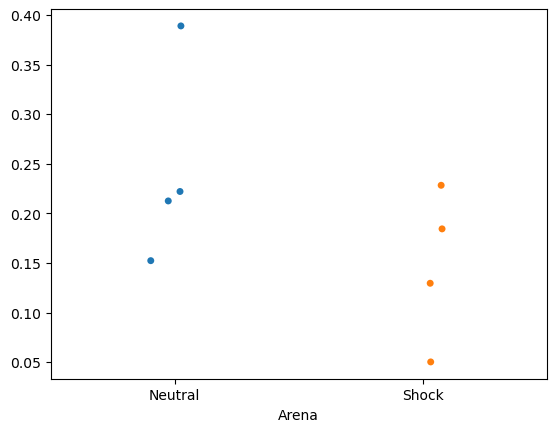

In [411]:
_, ax = plt.subplots()
sns.stripplot(data=df_mean_rs[df_mean_rs.Group == "Learners"], ax=ax)

In [429]:
df_mean.pivot(

,Group,Arena,mouse,corrs_sm,shuf_corrs_sm
0,ANI,Neutral,Marble17,0.174933,0.040564
1,ANI,Neutral,Marble18,0.375727,0.193367
2,ANI,Neutral,Marble19,0.353501,0.036869
3,ANI,Neutral,Marble20,0.267232,-0.070106
4,ANI,Neutral,Marble25,0.318481,0.073447
5,ANI,Shock,Marble17,0.099441,0.041483
6,ANI,Shock,Marble18,0.243411,0.093120
7,ANI,Shock,Marble19,0.294329,0.107434
8,ANI,Shock,Marble20,0.231902,0.152936
9,ANI,Shock,Marble25,0.265184,0.135155


In [431]:
df_bs

Group            boot_no  corrs_sm           shuf_corrs_sm  \
      Unnamed: 0_level_1 Unnamed: 1_level_1   Neutral     Shock       Neutral   
0               Learners                  0  0.162044  0.195162      0.028371   
1               Learners                  1  0.118048  0.119311      0.027619   
2               Learners                  2  0.401392  0.072274     -0.000115   
3               Learners                  3  0.201434  0.199475      0.019258   
4               Learners                  4  0.110834  0.217351      0.019263   
...                  ...                ...       ...       ...           ...   
29995                ANI               9995  0.253299  0.215664      0.022324   
29996                ANI               9996  0.112995  0.198513      0.008889   
29997                ANI               9997  0.195100  0.160532      0.046462   
29998                ANI               9998  0.288590  0.166782      0.057632   
29999                ANI               9999  0.087024  0.261394     -0.003450   

                 
          Shock  
0      0.056869  
1      0.074829  
2      0.101039  
3      0.119862  
4      0.078659  
...         ...  
29995  0.104155  
29996  0.065386  
29997  0.106602  
29998  0.088441  
29999  0.138338  

[30000 rows x 6 columns]

In [428]:
df_mean_rs

Arena,Group,mouse,Neutral,Shock
0,ANI,Marble17,0.174933,0.099441
1,ANI,Marble18,0.375727,0.243411
2,ANI,Marble19,0.353501,0.294329
3,ANI,Marble20,0.267232,0.231902
4,ANI,Marble25,0.318481,0.265184
5,Learners,Marble07,0.152266,0.228250
6,Learners,Marble12,0.388906,0.129483
7,Learners,Marble24,0.221996,0.184312
8,Learners,Marble27,0.212471,0.050179
9,Non-Learners,Marble06,0.275800,0.261770


(0.05401374554210444, 0.32489999999999997)
(-0.12222258439622362, 0.0138)
(-0.00922610136001164, 0.4798)


Text(0.5, 1.0, 'Before v After (Day -1 to 1)')

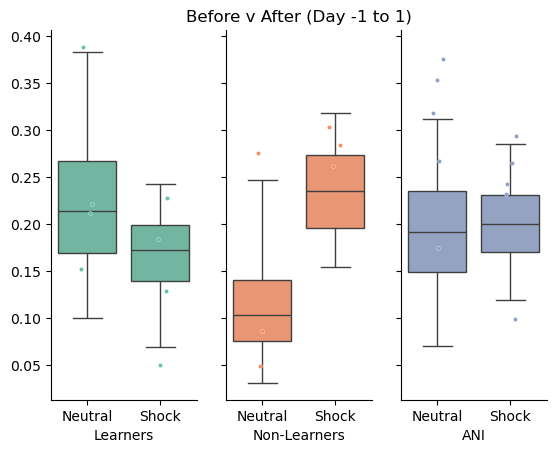

In [434]:
fig, ax = plt.subplots(1, 3, sharey=True)
epoch = 'Before v After Paired'
pal_use = sns.color_palette(palette='Set2', as_cmap=False)[0:3]
all_df = load_df(f"group_pf_corrs_{savename_dict[epoch]}")
df_mean = all_df.groupby(['Group', 'Arena', 'mouse', 'day_pair']).mean(numeric_only=True).reset_index().drop(columns=['day_pair', 'day1', 'day2', 'pair_no'])
df_mean_rs = df_mean.pivot(index=['Group', 'mouse'], columns='Arena', values='corrs_sm').reset_index()
for a, grp, color in zip(ax, ["Learners", "Non-Learners", "ANI"], pal_use):
    df_use = df_bs[df_bs.Group.iloc[:, 0] == grp]
    df_mean_use = df_mean_rs[df_mean_rs.Group == grp]
    print(get_bootstrap_prob_paired(df_use['corrs_sm']['Neutral'], df_use['corrs_sm']['Shock']))
    sns.boxplot(data=df_use['corrs_sm'], whis=(2.5, 97.5), showfliers=False, ax=a, color=color)
    sns.stripplot(data=df_mean_use, color=color, size=3, linewidth=0.2, edgecolor='w', ax=a)
    a.set_xlabel(grp)
sns.despine(fig=fig)
ax[1].set_title('Before v After (Day -1 to 1)')
# for a in ax[1:]:
    # sns.despine(ax=a, left=True)
    # a.set_yticks([])

In [273]:
t.set_names("Test", level=0, inplace=True)
t

MultiIndex([(        'Group', 'Unnamed: 0_level_1'),
            (      'boot_no', 'Unnamed: 1_level_1'),
            (     'corrs_sm',            'Neutral'),
            (     'corrs_sm',              'Shock'),
            ('shuf_corrs_sm',            'Neutral'),
            ('shuf_corrs_sm',              'Shock')],
           names=['Test', None])

In [323]:
df_bs[df_bs['Group'].iloc[:, 0] == "Learners"]

Group            boot_no  corrs_sm           shuf_corrs_sm  \
     Unnamed: 0_level_1 Unnamed: 1_level_1   Neutral     Shock       Neutral   
0              Learners                  0  0.162044  0.195162      0.028371   
1              Learners                  1  0.118048  0.119311      0.027619   
2              Learners                  2  0.401392  0.072274     -0.000115   
3              Learners                  3  0.201434  0.199475      0.019258   
4              Learners                  4  0.110834  0.217351      0.019263   
...                 ...                ...       ...       ...           ...   
9995           Learners               9995  0.307135  0.136598     -0.014037   
9996           Learners               9996  0.282184  0.087847     -0.010487   
9997           Learners               9997  0.275942  0.158974      0.010515   
9998           Learners               9998  0.229848  0.118484      0.021037   
9999           Learners               9999  0.274236  0.142326      0.029055   

                
         Shock  
0     0.056869  
1     0.074829  
2     0.101039  
3     0.119862  
4     0.078659  
...        ...  
9995  0.009111  
9996  0.009952  
9997  0.072348  
9998  0.030783  
9999  0.120644  

[10000 rows x 6 columns]

In [264]:
t = df_bs.columns
t
# t.set_names(['', '', 'Neutral', 'Shock', 'Neutral', 'Shock'], level=1)

MultiIndex([(        'Group', 'Unnamed: 0_level_1'),
            (      'boot_no', 'Unnamed: 1_level_1'),
            (     'corrs_sm',            'Neutral'),
            (     'corrs_sm',              'Shock'),
            ('shuf_corrs_sm',            'Neutral'),
            ('shuf_corrs_sm',              'Shock')],
           )

In [165]:
from copy import deepcopy
df_test = []
df_rs_mean = df_rs.drop(columns=["day1", "day2", "pair_no", "mouse_rs"]).groupby(['arena1']).mean(numeric_only=True).reset_index()
df_rs_mean.loc[df_rs_mean.arena1 == "Open", "arena1"] = "Neutral"
df_rs_mean.loc[:, "boot_no"] = 0
df_rs_mean.insert(0, "Group", group_name)
df_test.append(df_rs_mean)
df_rs_mean2 = deepcopy(df_rs_mean)
df_rs_mean2.loc[:, "boot_no"] = 1
df_test.append(df_rs_mean2)
df_test = pd.concat(df_test, axis=0, ignore_index=True).pivot(columns="arena1", values=["corrs_sm", "shuf_corrs_sm"], index="boot_no").reset_index()
# df_test.insert(0, "Group", group_name)
df_test

boot_no  corrs_sm           shuf_corrs_sm          
arena1           Neutral     Shock       Neutral     Shock
0            0  0.226638  0.147874      0.029769  0.066093
1            1  0.226638  0.147874      0.029769  0.066093

In [8]:
n_iter = 10000
best_rot = False
rot_append = "no_rot" if not best_rot else ""
rot_append

'no_rot'

In [14]:
day_dict

{'Before': [-2, -1],
 'Before v After': [-1, 1],
 'After': [1, 2],
 'After2': [2, 7],
 'Before v STM': [-1, 4],
 'STM v After': [4, 1]}

In [13]:
n_iter = 10000
best_rot = False
rot_append = "no_rot" if not best_rot else best_rot
for epoch in ["Before", "Before v After", "After", "After2", "Before v STM", "STM v After"]:
    df_bs, corr_df_all, shuf_df_all = [], [], []
    resample_levels = ["mouse", "session", "corrs_sm"]
    for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
        
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
            df_list, df_shuf_list = [], []
            for mouse in mice:
                day1, day2 = day_dict[epoch]
                df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2, use_best_rot=best_rot))
                df_shuf_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2, use_best_rot=best_rot, shuf_map=True))
    
            shuf_df = pd.concat(df_shuf_list)
            corr_df = pd.concat(df_list)
            corr_df.insert(0, column='Group', value=group_name)
            corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
            corr_df.insert(9, column="shuf_corrs_sm", value=shuf_df.corrs_sm.values)
            corr_df_all.append(corr_df)
    
            # shuf_df.insert(0, column='Group', value=group_name)
            # shuf_df.insert(1, colum n="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
            # shuf_df_all.append(shuf_df)
            
            means, shuf_means = [], []
            for ii in tqdm(range(n_iter)):
                t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
                means.append(t.corrs_sm.mean())
                shuf_means.append(t.shuf_corrs_sm.mean())
            df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means, 
                                      "Shuf Mean PF Corr": shuf_means}))
    df_bs = pd.concat(df_bs)
    corr_df_all = pd.concat(corr_df_all)
    corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
    corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"
    
    save_str = savename_dict[epoch]
    save_df(corr_df_all, f"group_pf_corrs_{save_str}_{rot_append}")
    save_df(df_bs, f"group_pf_corrs_{save_str}_{rot_append}_bootstrap")

100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 291.84it/s]


group_pf_corrs_before_after_no_rot.csv saved
group_pf_corrs_before_after_no_rot_bootstrap.csv saved


100%|████████████████████████████████████| 10000/10000 [00:33<00:00, 298.43it/s]


group_pf_corrs_after_no_rot.csv saved
group_pf_corrs_after_no_rot_bootstrap.csv saved


100%|████████████████████████████████████| 10000/10000 [00:30<00:00, 323.76it/s]


group_pf_corrs_after2_no_rot.csv saved
group_pf_corrs_after2_no_rot_bootstrap.csv saved


100%|████████████████████████████████████| 10000/10000 [00:32<00:00, 311.35it/s]


group_pf_corrs_before_stm_no_rot.csv saved
group_pf_corrs_before_stm_no_rot_bootstrap.csv saved


100%|████████████████████████████████████| 10000/10000 [00:30<00:00, 326.28it/s]


group_pf_corrs_stm_after_no_rot.csv saved
group_pf_corrs_stm_after_no_rot_bootstrap.csv saved


### Calculate Before v After (Day -1 to Day 1) correlations

In [ ]:
df_bs, corr_df_all = [], []
epoch = 'Before v After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_before_after")
save_df(df_bs, "group_pf_corrs_before_after_bootstrap")

### After correlations

In [ ]:
df_bs, corr_df_all = [], []
epoch = 'After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_after")
save_df(df_bs, "group_pf_corrs_after_bootstrap")

In [ ]:
df_bs, corr_df_all = [], []
epoch = 'After2'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_after2")
save_df(df_bs, "group_pf_corrs_after2_bootstrap")

#### STM (4hr) comparisons

In [ ]:
df_bs, corr_df_all = [], []
epoch = 'Before v STM'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_before_stm")
save_df(df_bs, "group_pf_corrs_before_stm_bootstrap")

In [ ]:
df_bs, corr_df_all = [], []
epoch = 'STM v After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_stm_after")
save_df(df_bs, "group_pf_corrs_stm_after_bootstrap")

### Quick and dirty sanity check plots
Looks good - matches mean data at mouse level from original submission.
real stuff in `Figure2_and_S4-5.ipynb`

In [ ]:
for varname, epoch_name in zip(["before", "before_after", "after", "after2"],
                               ["Before", "Before v After", "After", "After2"]):

    corr_df = load_df(f"group_pf_corrs_{varname}")
    boot_df = load_df(f"group_pf_corrs_{varname}_bootstrap")

    corr_df.loc[corr_df.Arena == "Open", "Arena"] = "Neutral" 
    corr_df["Group"] = pd.Categorical(corr_df["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_df["Arena"] = pd.Categorical(corr_df["Arena"], ["Neutral", "Shock"])
    
    boot_df["Group"] = pd.Categorical(boot_df["Group"], ["Learners", "Non-Learners", "ANI"])
    boot_df["Arena"] = pd.Categorical(boot_df["Arena"], ["Neutral", "Shock"])
    
    
    # corr_means = corr_df.groupby(["Group", "Arena", "mouse"]).mean(numeric_only=True).reset_index()
    # corr_means = corr_df.groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).
    corr_means = corr_df.drop(columns=["session_pair", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).reset_index()
    corr_means = corr_means.rename(columns={0: "corrs_sm"})
    corr_means["Group"] = pd.Categorical(corr_means["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_means["arena1"] = pd.Categorical(corr_means["Arena"], ["Neutral", "Shock"])
    
    _, ax = plt.subplots()
    pal_use = sns.color_palette(palette='Set2', as_cmap=False)[0:3] 
    sns.boxplot(data=boot_df, x="Arena", y="Mean PF Corr", hue="Group", showfliers=False, fill=False, palette=pal_use, ax=ax)
    sns.stripplot(data=corr_means, x="Arena", y="corrs_sm", hue="Group", dodge=True, palette=pal_use, linewidth=0.2, edgecolor='w',
                  ax=ax, legend=False)
    sns.despine(ax=ax)
    ax.set_title(epoch_name)

# PV1d correlation bootstraps

In [ ]:
rng = np.random.default_rng()
resample_mice = rng.choice(mice, size=len(mice), replace=True)
resample_mice


In [5]:
def resample_pv1d(mice, arena, day1, day2, shuf_map=False):
    rng = np.random.default_rng()
    resample_mice = rng.choice(mice, size=len(mice), replace=True)

    pv_corrs_both, pv_corrs_all = [], []
    for mouse in mice:
        # day1, day2 = day_dict[epoch]
        corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=True, shuf_map=shuf_map)
        pv_corrs_both.append(corr_both)
        pv_corrs_all.append(corr_all)

    return np.mean(pv_corrs_both), np.mean(pv_corrs_all)
resample_pv1d(err.learners, 'Shock', 1, 2)

(0.3338316671803213, -0.20040189480599838)

In [ ]:
def resample_pf2d(mice, arena, day1, day2, shuf_map=False):
    """Generally used to resample 2d place map correlations"""
    rng = np.random.default_rng()
    resample_mice = rng.choice(mice, size=len(mice), replace=True)

    pv_corrs_both, pv_corrs_all = [], []
    for mouse in mice:
        # day1, day2 = day_dict[epoch]
        corr_all, corr_both = pfs.pf_corr_bw_sesh_corr_bw_sesh(mouse, arena, day1, arena, day2, shuf_map=shuf_map)
        pv_corrs_both.append(corr_both)
        pv_corrs_all.append(corr_all)

    return np.mean(pv_corrs_both), np.mean(pv_corrs_all)

In [ ]:
# Code to test parallelization

from joblib import Parallel, delayed
import functools

arena = 'Shock'
day1, day2 = 1, 2

partial_resample = functools.partial(resample_pv1d, arena=arena, day1=day1, day2=day2)
n_iter = 10000
n_jobs = 8
out_df = []

data = [
    r
    for r in tqdm(
        Parallel(n_jobs=n_jobs, return_as="generator")(
            delayed(partial_resample)(err.learners) for _ in range(n_iter)
        ),
        total=n_iter,
        # position=1,
        # leave=False,
    )
]

In [6]:
from joblib import Parallel, delayed
import functools
def bootstrap_resample_pv1d(mice, arena, day1, day2, group, comparison, arena_rename, shuf_map=False, n_iter=1000, n_jobs=12):
    partial_resample = functools.partial(resample_pv1d, arena=arena, day1=day1, day2=day2, shuf_map=shuf_map)

    data = [
        r
        for r in tqdm(
            Parallel(n_jobs=n_jobs, return_as="generator")(
                delayed(partial_resample)(mice) for _ in range(n_iter)
            ),
            total=n_iter,
            # position=1,
            # leave=False,
        )
    ]
    return pd.DataFrame({"Group": group, "Arena": arena_rename, "Comparison": comparison, 
                         "Mean 1d PV Corr (Both)": np.array(data)[:, 0], "Mean 1d PV Corr (All)": np.array(data)[:,1]})

In [ ]:

for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        pv_means_both, pv_means_all = [], []
        print(f'resampling for {arena_name} {group_name}')

        day1, day2 = day_dict["Before"]
        data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
        boot_df.append(data)
boot_df = pd.concat(boot_df)

In [ ]:
# %%timeit
n_iter = 10000
df_bs, corr_df_all = [], []
epoch = 'Before'
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        pv_means_both, pv_means_all = [], []
        print(f'resampling for {arena_name} {group_name}')

        day1, day2 = day_dict[epoch]
        data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
        df_bs.append(data)
df_bs = pd.concat(df_bs, ignore_index=True)

# Do the same for session means without bootstrapping
pvcorr_df = []
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                            [err.learners, err.nonlearners, err.ani_mice_good]):

        pv_corrs_both, pv_corrs_all = [], []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
            pv_corrs_both.append(corr_both)
            pv_corrs_all.append(corr_all)
        pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                   "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))

pvcorr_df = pd.concat(pvcorr_df, ignore_index=True)

save_df(pvcorr_df, "group_pv1d_corrs_before")
save_df(df_bs, "group_pv1d_corrs_before_bootstrap")

In [ ]:

df_bs, corr_df_all = [], []
epoch = 'Before v After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        pv_means_both, pv_means_all = [], []
        print(f'resampling for {arena_name} {group_name}')

        day1, day2 = day_dict[epoch]
        data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
        df_bs.append(data)
df_bs = pd.concat(df_bs, ignore_index=True)

# Do the same for session means without bootstrapping
pvcorr_df = []
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                            [err.learners, err.nonlearners, err.ani_mice_good]):

        pv_corrs_both, pv_corrs_all = [], []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
            pv_corrs_both.append(corr_both)
            pv_corrs_all.append(corr_all)
        pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                   "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))

pvcorr_df = pd.concat(pvcorr_df, ignore_index=True)

save_df(pvcorr_df, "group_pv1d_corrs_before_after")
save_df(df_bs, "group_pv1d_corrs_before_after_bootstrap")

In [ ]:

df_bs, corr_df_all = [], []
epoch = 'After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        pv_means_both, pv_means_all = [], []
        print(f'resampling for {arena_name} {group_name}')

        day1, day2 = day_dict[epoch]
        data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
        df_bs.append(data)
df_bs = pd.concat(df_bs, ignore_index=True)

# Do the same for session means without bootstrapping
pvcorr_df = []
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                            [err.learners, err.nonlearners, err.ani_mice_good]):

        pv_corrs_both, pv_corrs_all = [], []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
            pv_corrs_both.append(corr_both)
            pv_corrs_all.append(corr_all)
        pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                   "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))

pvcorr_df = pd.concat(pvcorr_df, ignore_index=True)

save_df(pvcorr_df, "group_pv1d_corrs_after")
save_df(df_bs, "group_pv1d_corrs_after_bootstrap")

In [ ]:

df_bs, corr_df_all = [], []
epoch = 'Before v STM'
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        pv_means_both, pv_means_all = [], []
        print(f'resampling for {arena_name} {group_name}')

        day1, day2 = day_dict[epoch]
        data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
        df_bs.append(data)
df_bs = pd.concat(df_bs, ignore_index=True)

# Do the same for session means without bootstrapping
pvcorr_df = []
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                            [err.learners, err.nonlearners, err.ani_mice_good]):

        pv_corrs_both, pv_corrs_all = [], []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
            pv_corrs_both.append(corr_both)
            pv_corrs_all.append(corr_all)
        pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                   "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))

pvcorr_df = pd.concat(pvcorr_df, ignore_index=True)

save_df(pvcorr_df, "group_pv1d_corrs_before_stm")
save_df(df_bs, "group_pv1d_corrs_before_stm_bootstrap")

In [ ]:

df_bs, corr_df_all = [], []
epoch = 'STM v After'
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        pv_means_both, pv_means_all = [], []
        print(f'resampling for {arena_name} {group_name}')

        day1, day2 = day_dict[epoch]
        data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
        df_bs.append(data)
df_bs = pd.concat(df_bs, ignore_index=True)

# Do the same for session means without bootstrapping
pvcorr_df = []
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                            [err.learners, err.nonlearners, err.ani_mice_good]):

        pv_corrs_both, pv_corrs_all = [], []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
            pv_corrs_both.append(corr_both)
            pv_corrs_all.append(corr_all)
        pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                   "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))

pvcorr_df = pd.concat(pvcorr_df, ignore_index=True)

save_df(pvcorr_df, "group_pv1d_corrs_stm_after")
save_df(df_bs, "group_pv1d_corrs_stm_after_bootstrap")

In [71]:
n_iter = 10000
for epoch in ['Before', 'Before v After', 'After', 'After2', 'Before v STM', 'STM v After']:
    df_bs, df_shuf_bs, corr_df_all = [], [], []
    for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
        
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
            pv_means_both, pv_means_all = [], []
            print(f'resampling for {arena_name} {group_name}')
    
            day1, day2 = day_dict[epoch]
            data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, n_iter=n_iter)
            shuf_data = bootstrap_resample_pv1d(mice, arena, day1, day2, group_name, epoch, arena_name, shuf_map=True, n_iter=n_iter)
            df_bs.append(data)
            df_shuf_bs.append(shuf_data)
    df_bs = pd.concat(df_bs, ignore_index=True)
    df_shuf_bs = pd.concat(df_shuf_bs, ignore_index=True)
    
    # Merge shuffled values into main DataFrame
    df_bs = df_bs.merge(df_shuf_bs.rename(columns={"Mean 1d PV Corr (Both)" : "Shuf 1d PV Corr (Both)", 
                                                   "Mean 1d PV Corr (All)": "Shuf 1d PV Corr (All)"}), 
                        right_index=True, left_index=True, copy=False, 
                        suffixes=(None, "2")).drop(columns=["Group2", "Arena2", "Comparison2"])
    # Do the same for session means without bootstrapping
    pvcorr_df = []
    for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
    
            pv_corrs_both, pv_corrs_all = [], []
            for mouse in mice:
                day1, day2 = day_dict[epoch]
                corr_all, corr_both = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
                pv_corrs_both.append(corr_both)
                pv_corrs_all.append(corr_all)
            pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                           "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))
    
    pvcorr_df = pd.concat(pvcorr_df, ignore_index=True)

    save_str = savename_dict[epoch]
    save_df(pvcorr_df, f"group_pv1d_corrs_{save_str}")
    save_df(df_bs, f"group_pv1d_corrs_{save_str}_bootstrap")

resampling for Shock Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:15<00:00, 39.15it/s]


resampling for Shock Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:13<00:00, 31.91it/s]


resampling for Shock ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:17<00:00, 31.51it/s]


resampling for Neutral Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:56<00:00, 18.63it/s]


resampling for Neutral Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:18<00:00, 16.16it/s]


resampling for Neutral ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:41<00:00, 19.17it/s]


group_pv1d_corrs_before.csv saved
group_pv1d_corrs_before_bootstrap.csv saved
resampling for Shock Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:31<00:00, 65.92it/s]


resampling for Shock Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:34<00:00, 46.56it/s]


resampling for Shock ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:59<00:00, 33.34it/s]


resampling for Neutral Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:40<00:00, 29.37it/s]


resampling for Neutral Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:52<00:00, 24.24it/s]


resampling for Neutral ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:47<00:00, 21.40it/s]


group_pv1d_corrs_before_after.csv saved
group_pv1d_corrs_before_after_bootstrap.csv saved
resampling for Shock Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:43<00:00, 61.29it/s]


resampling for Shock Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:03<00:00, 32.94it/s]


resampling for Shock ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:39<00:00, 29.42it/s]


resampling for Neutral Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:10<00:00, 27.02it/s]


resampling for Neutral Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:37<00:00, 21.88it/s]


resampling for Neutral ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:09<00:00, 18.21it/s]


group_pv1d_corrs_after.csv saved
group_pv1d_corrs_after_bootstrap.csv saved
resampling for Shock Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:46<00:00, 44.11it/s]


resampling for Shock Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:28<00:00, 37.29it/s]


resampling for Shock ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:23<00:00, 30.88it/s]


resampling for Neutral Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:01<00:00, 23.71it/s]


resampling for Neutral Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:54<00:00, 18.71it/s]


resampling for Neutral ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:06<00:00, 18.29it/s]


group_pv1d_corrs_after2.csv saved
group_pv1d_corrs_after2_bootstrap.csv saved
resampling for Shock Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:17<00:00, 50.70it/s]


resampling for Shock Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:26<00:00, 30.59it/s]


resampling for Shock ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:17<00:00, 26.50it/s]


resampling for Neutral Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:11<00:00, 26.89it/s]


resampling for Neutral Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:53<00:00, 18.73it/s]


resampling for Neutral ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:15<00:00, 18.01it/s]


group_pv1d_corrs_before_stm.csv saved
group_pv1d_corrs_before_stm_bootstrap.csv saved
resampling for Shock Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:39<00:00, 62.89it/s]


resampling for Shock Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:00<00:00, 41.64it/s]


resampling for Shock ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:04<00:00, 40.85it/s]


resampling for Neutral Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:18<00:00, 31.42it/s]


resampling for Neutral Non-Learners


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:33<00:00, 17.45it/s]


resampling for Neutral ANI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:20<00:00, 22.69it/s]


group_pv1d_corrs_stm_after.csv saved
group_pv1d_corrs_stm_after_bootstrap.csv saved
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Shock day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found fo

In [ ]:
pvcorr_df = []
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                            [err.learners, err.nonlearners, err.ani_mice_good]):

        pv_corrs_both, pv_corrs_all = [], []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            corr_both, corr_all = pfs.PV1_corr_bw_sesh(mouse, arena, day1, arena, day2, bootstrap=False)
            pv_corrs_both.append(corr_both)
            pv_corrs_all.append(corr_all)
        pvcorr_df.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, 
                                   "1d PV Corr (Both)": pv_corrs_both, "1d PV Corr (All)": pv_corrs_all}))

In [ ]:
pd.concat(pvcorr_df, ignore_index=True)